# How to search the IOOS CSW catalog with Python tools


This notebook demonstrates a how to query the IOOS Catalog [Catalog Service for the Web (CSW)](https://en.wikipedia.org/wiki/Catalog_Service_for_the_Web), parse resulting records to obtain web data service endpoints, and retrieve data from these service endpoints.

Let's start by creating the search filters.
The filter used here constraints the search on a certain geographical region (bounding box), a time span (last week), and some [CF](http://cfconventions.org/Data/cf-standard-names/37/build/cf-standard-name-table.html) variable standard names that represent sea surface temperature.

In [1]:
from datetime import datetime

# Region: Northwest coast.
bbox = [-127, 43, -123.75, 48]
min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48

bbox = [min_lon, min_lat, max_lon, max_lat]
crs = "urn:ogc:def:crs:OGC:1.3:CRS84"

# Temporal range of 1 week.
start = datetime(2017, 4, 14, 0, 0, 0)
stop = datetime(2017, 4, 21, 0, 0, 0)

# Sea surface temperature CF names.
cf_names = [
    "sea_water_temperature",
    "sea_surface_temperature",
    "sea_water_potential_temperature",
    "equivalent_potential_temperature",
    "sea_water_conservative_temperature",
    "pseudo_equivalent_potential_temperature",
]

With these 3 elements it is possible to assemble a [OGC Filter Encoding (FE)](http://www.opengeospatial.org/standards/filter) using the `owslib.fes`\* module.

\* OWSLib is a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards, and their related content models.

Although CSW has a built-in feature to find datasets within a specified bounding box, it doesn't have a feature to find datasets within a specified time interval. We therefore create the function `fes_date_filter` below that finds all datasets that have at least part of their data within the specified interval.  So we find all datasets that start before the end of the interval and stop after the beginning of the interval.

In [2]:
from owslib import fes


def fes_date_filter(start, stop, constraint="overlaps"):
    """
    Take datetime-like objects and returns a fes filter for date range
    (begin and end inclusive).
    NOTE: Truncates the minutes!!!

    Examples
    --------
    >>> from datetime import datetime, timedelta
    >>> stop = datetime(2010, 1, 1, 12, 30, 59).replace(tzinfo=pytz.utc)
    >>> start = stop - timedelta(days=7)
    >>> begin, end = fes_date_filter(start, stop, constraint='overlaps')
    >>> begin.literal, end.literal
    ('2010-01-01 12:00', '2009-12-25 12:00')
    >>> begin.propertyoperator, end.propertyoperator
    ('ogc:PropertyIsLessThanOrEqualTo', 'ogc:PropertyIsGreaterThanOrEqualTo')
    >>> begin, end = fes_date_filter(start, stop, constraint='within')
    >>> begin.literal, end.literal
    ('2009-12-25 12:00', '2010-01-01 12:00')
    >>> begin.propertyoperator, end.propertyoperator
    ('ogc:PropertyIsGreaterThanOrEqualTo', 'ogc:PropertyIsLessThanOrEqualTo')

    """
    start = start.strftime("%Y-%m-%d %H:00")
    stop = stop.strftime("%Y-%m-%d %H:00")
    if constraint == "overlaps":
        propertyname = "apiso:TempExtent_begin"
        begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname, literal=stop)
        propertyname = "apiso:TempExtent_end"
        end = fes.PropertyIsGreaterThanOrEqualTo(
            propertyname=propertyname, literal=start
        )
    elif constraint == "within":
        propertyname = "apiso:TempExtent_begin"
        begin = fes.PropertyIsGreaterThanOrEqualTo(
            propertyname=propertyname, literal=start
        )
        propertyname = "apiso:TempExtent_end"
        end = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname, literal=stop)
    else:
        raise NameError("Unrecognized constraint {}".format(constraint))
    return begin, end

In [3]:
kw = dict(wildCard="*", escapeChar="\\", singleChar="?", propertyname="apiso:AnyText")

or_filt = fes.Or([fes.PropertyIsLike(literal=("*%s*" % val), **kw) for val in cf_names])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)

filter_list = [
    fes.And(
        [
            bbox_crs,  # bounding box
            begin,
            end,  # start and end date
            or_filt,  # or conditions (CF variable names)
        ]
    )
]

In [4]:
from owslib.csw import CatalogueServiceWeb

endpoint = "https://data.ioos.us/csw"

csw = CatalogueServiceWeb(endpoint, timeout=60)

We have created a `csw` object, but nothing has been searched yet.

Below we create a `get_csw_records` function that calls the OSWLib method `getrecords2` iteratively to retrieve all the records matching the search criteria specified by the `filter_list`.

In [5]:
def get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000):
    """Iterate `maxrecords`/`pagesize` times until the requested value in
    `maxrecords` is reached.
    """
    from owslib.fes import SortBy, SortProperty

    # Iterate over sorted results.
    sortby = SortBy([SortProperty("dc:title", "ASC")])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, "results", 1)
    while nextrecord != 0:
        csw.getrecords2(
            constraints=filter_list,
            startposition=startposition,
            maxrecords=pagesize,
            sortby=sortby,
        )
        csw_records.update(csw.records)
        if csw.results["nextrecord"] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [6]:
get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = "\n".join(csw.records.keys())
print("Found {} records.\n".format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print(u"[{}]\n{}\n".format(value.title, key))

Found 82 records.

[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 station, Westport, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9441102

[urn:ioos:station:NOAA.NOS.CO-OPS:9442396 station, La Push, Quillayute River, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9442396

[Astoria Canyon, OR  (179)]
sdf.ndbc.noaa.gov-urn_ioos_station_wmo_46248

[CAPE ELIZABETH- 45NM NW of Aberdeen, WA]
sdf.ndbc.noaa.gov-urn_ioos_station_wmo_46041

[ce_312-20170419T2040-delayed]
org.oceanobservatories:ce_312-20170419T2040-delayed_f070_8f49_1646

[ce_312-20170419T2040-delayed]
ce_312-20170419T2040-delayed

[ce_319-20170410T2034]
ce_319-20170410T2034

[ce_319-20170410T2034]
org.oceanobservatories:ce_319-20170410T2034_f070_8f49_1646

[ce_319-20170410T2034-delayed]
ce_319-20170410T2034-delayed

[ce_319-20170410T2034-delayed]
org.oceanobservatories:ce_319-20170410T2034-delayed_f070_8f49_1646

[ce_320-20170410T1745]
org.oceanobservatories:ce_320-20170410T1745_f070_8f49_1646

[

That search returned a lot of records!
What if we are not interested in those model results nor global dataset?
We can those be excluded  from the search with a `fes.Not` filter.

In [7]:
kw = dict(wildCard="*", escapeChar="\\\\", singleChar="?", propertyname="apiso:AnyText")


filter_list = [
    fes.And(
        [
            bbox_crs,  # Bounding box
            begin,
            end,  # start and end date
            or_filt,  # or conditions (CF variable names).
            fes.Not([fes.PropertyIsLike(literal="*NAM*", **kw)]),  # no NAM results
            fes.Not([fes.PropertyIsLike(literal="*CONUS*", **kw)]),  # no NAM results
            fes.Not([fes.PropertyIsLike(literal="*GLOBAL*", **kw)]),  # no NAM results
            fes.Not([fes.PropertyIsLike(literal="*ROMS*", **kw)]),  # no NAM results
        ]
    )
]

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = "\n".join(csw.records.keys())
print("Found {} records.\n".format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print(u"[{}]\n{}\n".format(value.title, key))

Found 69 records.

[UNH Appledore Island CO2]
UNH_WBD

[urn:ioos:station:NOAA.NOS.CO-OPS:9432780 station, Charleston, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9432780

[urn:ioos:station:NOAA.NOS.CO-OPS:9435380 station, South Beach, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9435380

[urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540

[urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040

[urn:ioos:station:NOAA.NOS.CO-OPS:9440581 station, Cape Disappointment, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440581

[urn:ioos:station:NOAA.NOS.CO-OPS:9440910 station, Toke Point, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440910

[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 station, Westport, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NO

Now we got fewer records to deal with. That's better. But if the user is interested in only some specific service, it is better to filter by a string, like [`CO-OPS`](https://tidesandcurrents.noaa.gov/).

In [8]:
filter_list = [
    fes.And(
        [
            bbox_crs,  # Bounding box
            begin,
            end,  # start and end date
            or_filt,  # or conditions (CF variable names).
            fes.PropertyIsLike(literal="*CO-OPS*", **kw),  # must have CO-OPS
        ]
    )
]

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = "\n".join(csw.records.keys())
print("Found {} records.\n".format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print("[{}]\n{}\n".format(value.title, key))

Found 8 records.

[urn:ioos:station:NOAA.NOS.CO-OPS:9432780 station, Charleston, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9432780

[urn:ioos:station:NOAA.NOS.CO-OPS:9435380 station, South Beach, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9435380

[urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540

[urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040

[urn:ioos:station:NOAA.NOS.CO-OPS:9440581 station, Cape Disappointment, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440581

[urn:ioos:station:NOAA.NOS.CO-OPS:9440910 station, Toke Point, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440910

[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 station, Westport, WA]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9441102

[urn:ioos:station:N

The easiest way to get more information is to explorer the individual records.
Here is the `abstract` and `subjects` from the station in Astoria, OR.

In [9]:
import textwrap

value = csw.records[
    "opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040"
]

print("\n".join(textwrap.wrap(value.abstract)))

NOAA.NOS.CO-OPS Sensor Observation Service (SOS) Server  This station
provides the following variables: Air pressure, Air temperature, Sea
surface height amplitude due to equilibrium ocean tide, Sea water
temperature, Water surface height above reference datum, Wind from
direction, Wind speed, Wind speed of gust


In [10]:
print("\n".join(value.subjects))

Air Temperature
Barometric Pressure
Conductivity
Currents
Datum
Harmonic Constituents
Rain Fall
Relative Humidity
Salinity
Visibility
Water Level
Water Level Predictions
Water Temperature
Winds
air_pressure
air_temperature
sea_surface_height_amplitude_due_to_equilibrium_ocean_tide
sea_water_temperature
water_surface_height_above_reference_datum
wind_from_direction
wind_speed
wind_speed_of_gust
climatologyMeteorologyAtmosphere


The next step is to inspect the type services/schemes available for downloading the data. The easiest way to accomplish that is with by "sniffing" the URLs with `geolinks`.

In [11]:
from geolinks import sniff_link

msg = "geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n".format
for ref in value.references:
    print(msg(geolink=sniff_link(ref["url"]), **ref))

geolink: OGC:SOS
scheme: Astoria
URL: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?request=DescribeSensor&outputFormat=text/xml; subtype="sensorML/1.0.1/profiles/ioos_sos/1.0"&version=1.0.0&procedure=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&service=SOS

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&version=1.0.0&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/air_pressure&responseFormat=text/csv&eventTime=2020-04-23T16:13:27/2020-04-23T18:13:27&service=SOS

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&version=1.0.0&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/air_temperature&responseFormat=text/csv&eventTime=2020-04-23T16:13:27/2020-04-23T18:13:27&service=SOS

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http:

There are many direct links to Comma Separated Value (`CSV`) and
eXtensible Markup Language (`XML`) responses to the various variables available in that station. 

In addition to those links, there are three very interesting links for more information: 1.) the QC document, 2.) the station photo, 3.) the station home page.


For a detailed description of what those `geolink` results mean check the [lookup](https://github.com/OSGeo/Cat-Interop/blob/master/LinkPropertyLookupTable.csv) table.


![](https://tidesandcurrents.noaa.gov/images/stationphotos/9439040A.jpg)

The original search was focused on sea water temperature,
so there is the need to extract only the endpoint for that variable.

PS: see also the [pyoos example](http://ioos.github.io/notebooks_demos/notebooks/2016-10-12-fetching_data/) for fetching data from `CO-OPS`.

In [12]:
start, stop

(datetime.datetime(2017, 4, 14, 0, 0), datetime.datetime(2017, 4, 21, 0, 0))

In [13]:
for ref in value.references:
    url = ref["url"]
    if "csv" in url and "sea" in url and "temperature" in url:
        print(msg(geolink=sniff_link(url), **ref))
        break

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&version=1.0.0&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature&responseFormat=text/csv&eventTime=2020-04-23T16:13:27/2020-04-23T18:13:27&service=SOS



Note that the URL returned by the service has some hard-coded start/stop dates.
It is easy to overwrite those with the same dates from the filter.

In [14]:
fmt = (
    "https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?"
    "service=SOS&"
    "eventTime={0:%Y-%m-%dT00:00:00}/{1:%Y-%m-%dT00:00:00}&"
    "observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature&"
    "version=1.0.0&"
    "request=GetObservation&offering=urn:ioos:station:NOAA.NOS.CO-OPS:9439040&"
    "responseFormat=text/csv"
)

url = fmt.format(start, stop)

Finally, it is possible to download the data directly into a data `pandas` data frame and plot it.

In [15]:
import io

import pandas as pd
import requests

r = requests.get(url)

df = pd.read_csv(
    io.StringIO(r.content.decode("utf-8")), index_col="date_time", parse_dates=True
)

Text(0.5, 1.0, 'urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR')

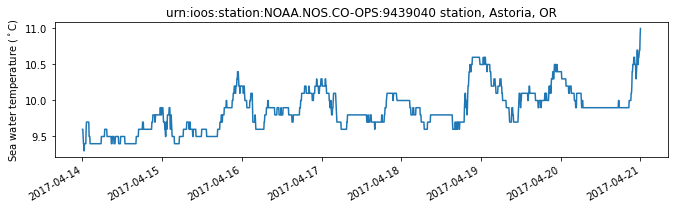

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 2.75))
ax = df["sea_water_temperature (C)"].plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel(r"Sea water temperature ($^\circ$C)")
ax.set_title(value.title)